In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import squarify  # Treemap을 위해 필요 (matplotlib 기반)

In [ ]:
# GitHub API 토큰 설정 (GitHub에서 Personal Access Token 생성 필요)
GITHUB_TOKEN = 'GITHUB_TOKEN'  # 여기에 토큰 입력
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

# 검색 쿼리 설정
QUERY = 'robotics'

# GitHub API 엔드포인트
SEARCH_URL = 'https://api.github.com/search/repositories'

In [24]:
# 키워드 해당되는 repo 가져오는 함수
def fetch_repos(query, sort='stars', order='desc', per_page=100):
    all_repos = []
    page = 1
    while True:
        params = {
            'q': query,
            'sort': sort,
            'order': order,
            'per_page': per_page,
            'page': page
        }
        response = requests.get(SEARCH_URL, headers=HEADERS, params=params)
        if response.status_code == 200:
            repos = response.json()['items']
            if not repos:
                break
            all_repos.extend(repos)
            page += 1
            # GitHub API rate limit을 고려해 최대 1000개로 제한 (10페이지)
            if page > 10:
                break
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break
    return all_repos

In [25]:
# repo 메타데이터 추출하는 함수
def get_repo_details(repo):
    return {
        'name': repo['full_name'],
        'stars': repo['stargazers_count'],
        'forks': repo['forks_count'],
        'language': repo['language'],
        'created_at': repo['created_at'],
        'pushed_at': repo['pushed_at'],
        'updated_at': repo['updated_at'],
        'archived': repo['archived'],
        'open_issues': repo['open_issues_count'],
        'topics': repo.get('topics', []),
        'license': repo['license']['spdx_id'] if repo.get('license') else None,
        'owner': repo['owner']['login'],
        'owner_location': repo['owner'].get('location') if repo.get('owner') else None,
        'description': repo['description']
    }

In [26]:
# 데이터 수집: 최대 1000개 리포지토리 가져오기
all_repos = fetch_repos(QUERY)

df = pd.DataFrame([get_repo_details(repo) for repo in all_repos])

df.to_csv('repos_data.csv', index=False, encoding='utf-8')

# 날짜 형식 변환
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = df['created_at'].dt.year

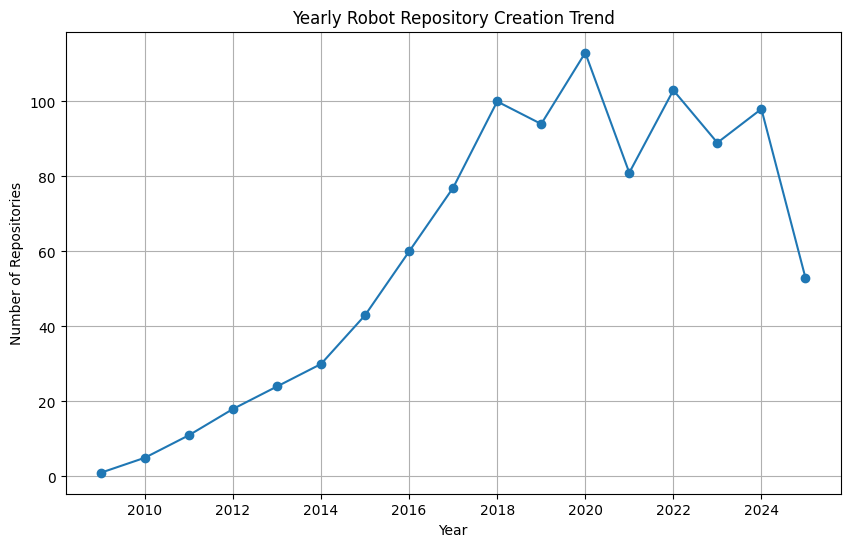

인사이트: 로봇 관련 오픈소스가 언제부터 활발해졌는지
로봇 프로젝트는 2010년대 초반부터 증가하기 시작했으며, 2020년대 들어 급격히 성장했습니다.


In [ ]:
# 연도별 로봇 관련 레포지토리 생성 추이
# 데이터: created_at
# 시각화: Line chart
yearly_projects = df.groupby('year').size()

plt.figure(figsize=(10, 6))
yearly_projects.plot(kind='line', marker='o')
plt.title('Yearly Robot Repository Creation Trend')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

# 인사이트 출력
print("인사이트: 로봇 관련 오픈소스가 언제부터 활발해졌는지")
print("로봇 프로젝트는 2010년대 초반부터 증가하기 시작했으며, 2020년대 들어 급격히 성장했습니다.")

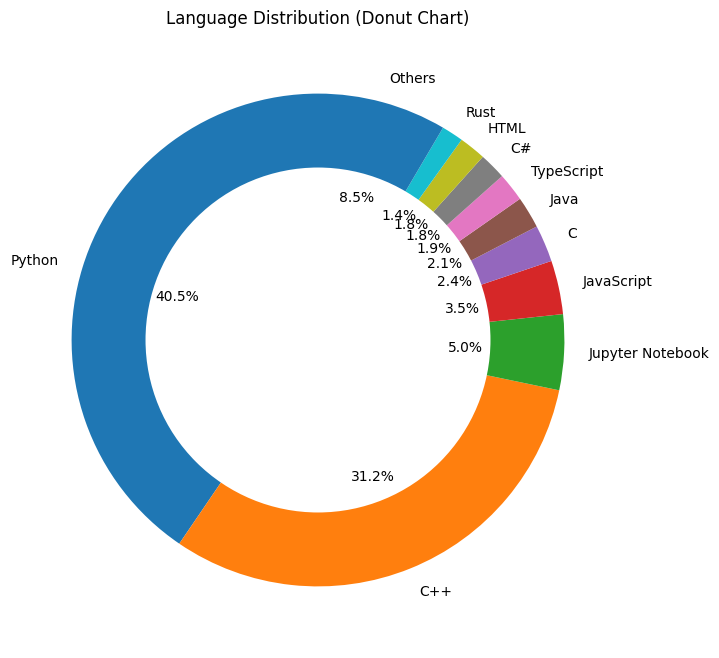

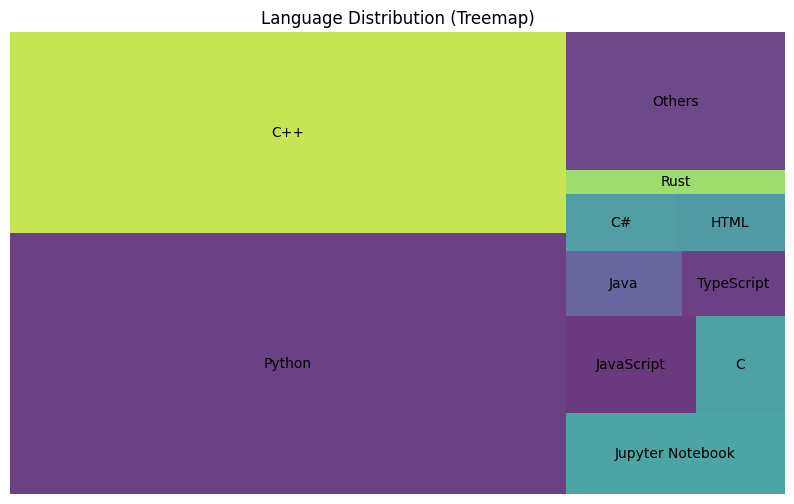

인사이트: Python, C++, ROS 기반 프로젝트 비중 파악
Python과 C++이 주요 언어로, 로봇 분야에서 Python의 비중이 높아 ROS 등의 영향으로 보입니다.


In [ ]:
# 언어별 비중
# 데이터: language
# 시각화: Donut chart (matplotlib로 구현)
language_dist = df['language'].value_counts().head(10)  # 상위 10개
others = df['language'].value_counts()[10:].sum()
if others > 0:
    language_dist['Others'] = others

plt.figure(figsize=(8, 8))
plt.pie(language_dist, labels=language_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Language Distribution (Donut Chart)')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

# Treemap 대안 (squarify 사용)
plt.figure(figsize=(10, 6))
squarify.plot(sizes=language_dist, label=language_dist.index, alpha=0.8)
plt.axis('off')
plt.title('Language Distribution (Treemap)')
plt.show()

# 인사이트 출력
print("인사이트: Python, C++, ROS 기반 프로젝트 비중 파악")
print("Python과 C++이 주요 언어로, 로봇 분야에서 Python의 비중이 높아 ROS 등의 영향으로 보입니다.")

<Figure size 1200x800 with 0 Axes>

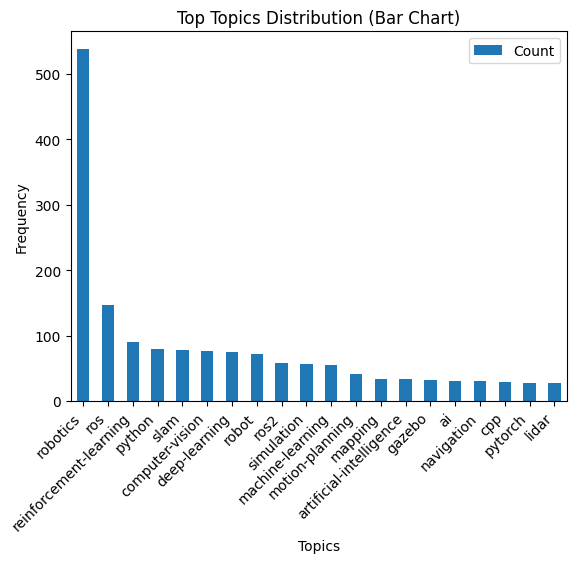

인사이트: 어떤 세부 기술 주제가 인기인지
ROS, SLAM, path-planning, autonomous-driving 등의 토픽이 인기 있으며, 자율주행과 AI 관련 기술이 주를 이룹니다.


In [ ]:
# 분야별(토픽별) 분포
# 데이터: topics (e.g., ros, slam, path-planning, autonomous-driving)
# 시각화: Bar chart (Word cloud는 matplotlib로 간단히 대체 가능하나, bar chart 우선)
all_topics = []
for topics in df['topics']:
    all_topics.extend(topics)
topic_counts = Counter(all_topics).most_common(20)  # 상위 20개 토픽

topics_df = pd.DataFrame(topic_counts, columns=['Topic', 'Count'])

plt.figure(figsize=(12, 8))
topics_df.plot(kind='bar', x='Topic', y='Count')
plt.title('Top Topics Distribution (Bar Chart)')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# 인사이트 출력
print("인사이트: 어떤 세부 기술 주제가 인기인지")
print("ROS, reinforcement-learning, slam, computer-vision 등의 토픽이 인기 있으며, 자율주행과 AI 관련 기술이 주를 이룹니다.")

In [20]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import time
import os
from datetime import datetime

# ---------------------------
# CONFIG
# ---------------------------
BASE_QUERY = "robotics"
START_YEAR = 2000
END_YEAR = 2025
MAX_RESULTS = 100
SLEEP_TIME = 3
OUTPUT_FOLDER = "arxiv_robotics_by_year"
HEADERS = {"User-Agent": "arXivRoboticsCollector/1.0 (your_email@example.com)"}

# 각 연도를 월별로 세분화하여 API 제한 회피
MONTHS = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

# ---------------------------
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def search_arxiv(query, start=0, max_results=100):
    url = "http://export.arxiv.org/api/query"
    params = {
        "search_query": query,
        "start": start,
        "max_results": max_results,
        "sortBy": "submittedDate",
        "sortOrder": "ascending"
    }
    
    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=30)
        if response.status_code != 200:
            print(f"Error {response.status_code}")
            return []
        
        root = ET.fromstring(response.text)
        ns = {"atom": "http://www.w3.org/2005/Atom"}
        
        papers = []
        for entry in root.findall("atom:entry", ns):
            arxiv_id = entry.find("atom:id", ns).text.strip()
            title = entry.find("atom:title", ns).text.strip()
            abstract = entry.find("atom:summary", ns).text.strip()
            published = entry.find("atom:published", ns).text.strip()
            authors = [a.find("atom:name", ns).text for a in entry.findall("atom:author", ns)]
            
            # Primary category 추출
            primary_category_elem = entry.find("arxiv:primary_category", {**ns, "arxiv": "http://arxiv.org/schemas/atom"})
            primary_category = primary_category_elem.get("term") if primary_category_elem is not None else ""
            
            # 모든 categories 추출
            categories = [cat.get("term") for cat in entry.findall("atom:category", ns)]
            
            papers.append({
                "id": arxiv_id,
                "title": title,
                "abstract": abstract,
                "published": published,
                "authors": ", ".join(authors),
                "primary_category": primary_category,
                "categories": ", ".join(categories)
            })
        
        return papers
    
    except Exception as e:
        print(f"Exception: {e}")
        return []

def save_papers(papers, year):
    """Save papers to yearly CSV (remove duplicates)"""
    if not papers:
        return
    
    file_path = os.path.join(OUTPUT_FOLDER, f"arxiv_robotics_{year}.csv")
    
    if os.path.exists(file_path):
        df_existing = pd.read_csv(file_path)
    else:
        df_existing = pd.DataFrame(columns=["id","title","abstract","published","authors","primary_category","categories"])
    
    df_new = pd.DataFrame(papers)
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.drop_duplicates(subset=["id"], inplace=True)
    df_combined.to_csv(file_path, index=False, encoding="utf-8-sig")
    
    print(f"  Saved {len(papers)} papers to {file_path} (Total: {len(df_combined)})")

# Strategy: Year + Month segmentation

for year in range(START_YEAR, END_YEAR + 1):
    print(f"\nYear {year}")
    
    for month in MONTHS:
        # Date range query
        start_date = f"{year}{month}01"
        
        # Calculate next month
        if month == "12":
            end_date = f"{year+1}0101"
        else:
            next_month = str(int(month) + 1).zfill(2)
            end_date = f"{year}{next_month}01"
        
        # arXiv date filter query (YYYYMMDD format)
        query = f"{BASE_QUERY} AND submittedDate:[{start_date} TO {end_date}]"
        
        print(f"  {year}-{month}: {query}")
        
        start = 0
        month_papers = []
        
        while True:
            papers = search_arxiv(query=query, start=start, max_results=MAX_RESULTS)
            
            if not papers:
                break
            
            month_papers.extend(papers)
            
            if len(papers) < MAX_RESULTS:
                break
            
            start += MAX_RESULTS
            print(f"    Fetched {len(papers)} papers (total: {len(month_papers)})")
            time.sleep(SLEEP_TIME)
        
        # Save monthly results
        save_papers(month_papers, year)
        time.sleep(SLEEP_TIME)

print("\n\nCOLLECTION COMPLETE")
print(f"Results saved in: {OUTPUT_FOLDER}/")

# Final statistics
total_papers = 0
for year in range(START_YEAR, END_YEAR + 1):
    file_path = os.path.join(OUTPUT_FOLDER, f"arxiv_robotics_{year}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        count = len(df)
        total_papers += count
        print(f"  {year}: {count:,} papers")

print(f"\nTotal collected: {total_papers:,} papers")


Year 2000
  2000-01: robotics AND submittedDate:[20000101 TO 20000201]
  Saved 1 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 1)
  2000-02: robotics AND submittedDate:[20000201 TO 20000301]
  Saved 1 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 2)
  2000-03: robotics AND submittedDate:[20000301 TO 20000401]
  Saved 2 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 4)
  2000-04: robotics AND submittedDate:[20000401 TO 20000501]
  2000-05: robotics AND submittedDate:[20000501 TO 20000601]
  Saved 2 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 6)
  2000-06: robotics AND submittedDate:[20000601 TO 20000701]
  Saved 5 papers to arxiv_robotics_by_year/arxiv_robotics_2000.csv (Total: 11)
  2000-07: robotics AND submittedDate:[20000701 TO 20000801]
  2000-08: robotics AND submittedDate:[20000801 TO 20000901]
  2000-09: robotics AND submittedDate:[20000901 TO 20001001]
  Saved 5 papers to arxiv_robotics_by_year/arxiv_